# Compare GPs + Plot

In [9]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
import itertools
from matplotlib import pyplot
import tueplots.figsizes

In [10]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [11]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]

## True Function

In [12]:
d = 1
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768):
    return (x**2+x)[:,0]
    return (x*np.exp(x)).sum(-1)
    # https://www.sfu.ca/~ssurjano/ackley.html
    assert x.ndim==2
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y

## Parameters

In [13]:
n = 2**2
xticks = torch.linspace(0,1,501,device=device)
yticks = f_ackley(xticks[:,None])

## Standard GP

  n = 4
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.51e-02   | 4.51e-02  
            5.00e+00 | -4.44e-01  | -4.44e-01 
            1.00e+01 | -5.50e-01  | -5.20e-01 
            1.50e+01 | -5.50e-01  | -5.44e-01 
            1.60e+01 | -5.50e-01  | -5.44e-01 
    posterior cubature var: n = 4 3.09e-05  n = 8 1.29e-05  n = 16 6.27e-06  n = 32 3.13e-06  n = 64 1.56e-06  


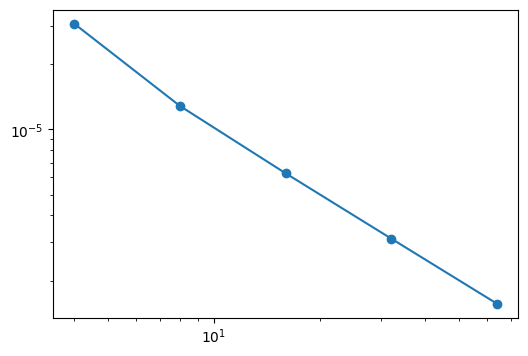

In [14]:
print("  n = %d"%n)
sgp = fastgps.StandardGP(
    qp.KernelSquaredExponential(d,torchify=True,device=device),
    qp.DigitalNetB2(d,seed=11),
    )
x_next = sgp.get_x_next(n)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_n,pstd_std_n,q,ci_low_std_n,ci_high_std_n = sgp.post_ci(xticks[:,None])
x_std_n,y_std_n = sgp.x.clone(),sgp.y.clone()
nprojs = [n,2*n,4*n,8*n,16*n]
vprojs = [sgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(6,4))
ax.set_xscale("log",base=10)
ax.set_yscale("log",base=10)
ax.plot(nprojs,vprojs,'-o');

  n = 8
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | -1.24e+01  | -1.24e+01 
            5.00e+00 | -1.28e+01  | -1.28e+01 
            1.00e+01 | -1.29e+01  | -1.29e+01 
            1.50e+01 | -1.29e+01  | -1.29e+01 
            1.60e+01 | -1.29e+01  | -1.29e+01 
    posterior cubature var: n = 8 1.27e-05  n = 16 6.27e-06  n = 32 3.13e-06  n = 64 1.56e-06  n = 128 7.87e-07  


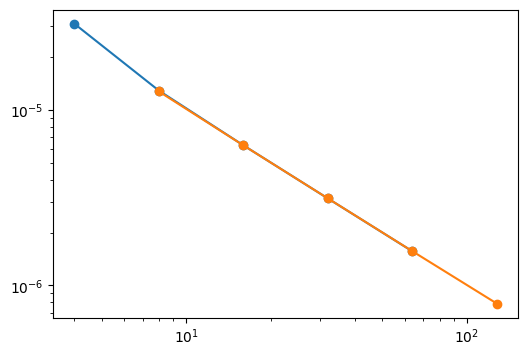

In [15]:
print("  n = %d"%(2*n))
x_next = sgp.get_x_next(2*n)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_2n,pstd_std_2n,q,ci_low_std_2n,ci_high_std_2n = sgp.post_ci(xticks[:,None])
x_std_2n,y_std_2n = sgp.x.clone(),sgp.y.clone()
nprojs = [2*n,4*n,8*n,16*n,32*n]
vprojs = [sgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
ax.plot(nprojs,vprojs,'-o')
fig

  n = 16
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | -4.10e+01  | -4.10e+01 
            5.00e+00 | -4.11e+01  | -4.11e+01 
            1.00e+01 | -4.11e+01  | -4.11e+01 
    posterior cubature var: n = 16 6.26e-06  n = 32 3.12e-06  n = 64 1.57e-06  n = 128 7.87e-07  n = 256 4.01e-07  


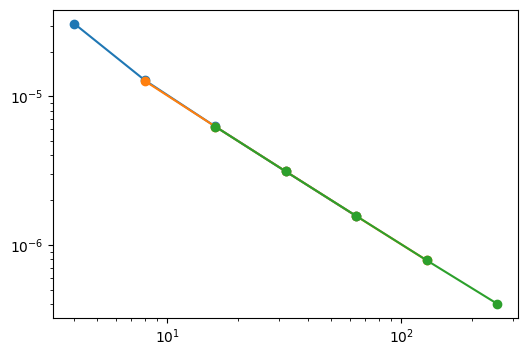

In [16]:
print("  n = %d"%(4*n))
x_next = sgp.get_x_next(4*n)
assert x_next.shape==(2*n,1)
y_next = f_ackley(x_next)
sgp.add_y_next(y_next)
sgp.fit()
pmean_std_4n,pstd_std_4n,q,ci_low_std_4n,ci_high_std_4n = sgp.post_ci(xticks[:,None])
x_std_4n,y_std_4n = sgp.x.clone(),sgp.y.clone()
nprojs = [4*n,8*n,16*n,32*n,64*n]
vprojs = [sgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
ax.plot(nprojs,vprojs,'-o')
fig

## Lattice

  n = 4
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.75e+00   | 5.75e+00  
            5.00e+00 | 4.22e+00   | 4.22e+00  
            1.00e+01 | 4.13e+00   | 4.13e+00  
            1.50e+01 | 4.00e+00   | 4.00e+00  
            2.00e+01 | 3.90e+00   | 3.90e+00  
            2.50e+01 | 3.69e+00   | 3.69e+00  
            3.00e+01 | 3.34e+00   | 3.34e+00  
            3.50e+01 | 3.18e+00   | 3.18e+00  
            4.00e+01 | 3.05e+00   | 3.05e+00  
            4.50e+01 | 2.94e+00   | 2.94e+00  
            5.00e+01 | 2.67e+00   | 2.67e+00  
            5.50e+01 | 2.19e+00   | 2.19e+00  
            6.00e+01 | 1.74e+00   | 1.74e+00  
            6.50e+01 | 1.37e+00   | 1.37e+00  
            7.00e+01 | 1.34e+00   | 1.66e+00  
            7.50e+01 | 1.34e+00   | 1.40e+00  
            7.60e+01 | 1.34e+00   | 1.35e+00  
    posterior cubature var: n = 4 7.74e-06  n = 8 7.12e-06  n = 16 3.12e-06  n = 32 3.12e-07  n = 6

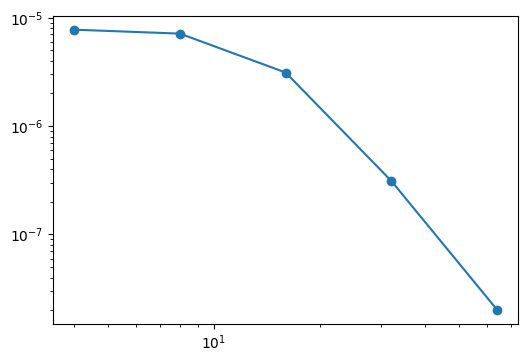

In [17]:
print("  n = %d"%n)
fgp = fastgps.FastGPLattice(
    qp.KernelShiftInvar(d,torchify=True,device=device),
    qp.Lattice(d,seed=7),
    )
x_next = fgp.get_x_next(n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_n,pstd_lattice_n,q,ci_low_lattice_n,ci_high_lattice_n = fgp.post_ci(xticks[:,None])
x_lattice_n,y_lattice_n = fgp.x.clone(),fgp.y.clone()
nprojs = [n,2*n,4*n,8*n,16*n]
vprojs = [fgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(6,4))
ax.set_xscale("log",base=10)
ax.set_yscale("log",base=10)
ax.plot(nprojs,vprojs,'-o');

  n = 8
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.28e+01   | 1.28e+01  
            5.00e+00 | 5.03e+00   | 5.03e+00  
            1.00e+01 | 5.03e+00   | 5.03e+00  
            1.50e+01 | 5.03e+00   | 5.03e+00  
    posterior cubature var: n = 8 1.32e-05  n = 16 8.54e-06  n = 32 1.29e-06  n = 64 8.84e-08  n = 128 5.56e-09  


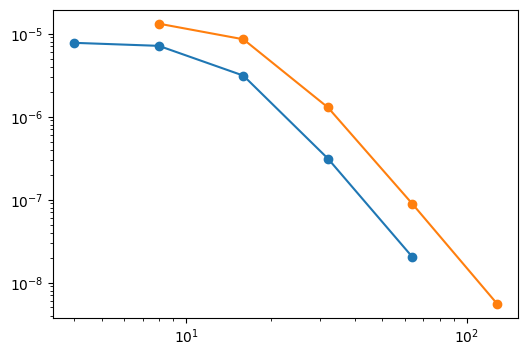

In [18]:
print("  n = %d"%(2*n))
x_next = fgp.get_x_next(2*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_2n,pstd_lattice_2n,q,ci_low_lattice_2n,ci_high_lattice_2n = fgp.post_ci(xticks[:,None])
x_lattice_2n,y_lattice_2n = fgp.x.clone(),fgp.y.clone()
nprojs = [2*n,4*n,8*n,16*n,32*n]
vprojs = [fgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
ax.plot(nprojs,vprojs,'-o');
fig

  n = 16
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.60e+01   | 2.60e+01  
            5.00e+00 | 1.12e+01   | 1.12e+01  
            1.00e+01 | 1.12e+01   | 1.12e+01  
            1.50e+01 | 1.12e+01   | 1.12e+01  
    posterior cubature var: 2.23e-05   n=32: 5.12e-06   n=64: 3.85e-07  
    posterior cubature var: n = 16 2.23e-05  n = 32 5.12e-06  n = 64 3.85e-07  n = 128 2.44e-08  n = 256 1.52e-09  


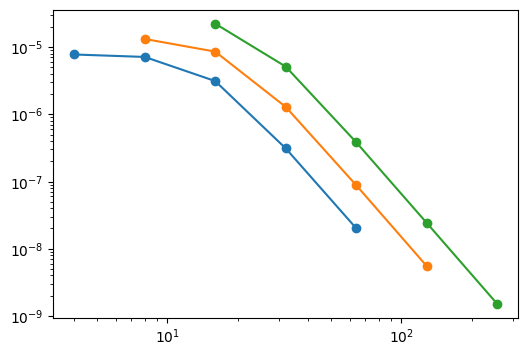

In [19]:
print("  n = %d"%(4*n))
x_next = fgp.get_x_next(4*n)
assert x_next.shape==(2*n,1)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_lattice_4n,pstd_lattice_4n,q,ci_low_lattice_4n,ci_high_lattice_4n = fgp.post_ci(xticks[:,None])
x_lattice_4n,y_lattice_4n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),8*n,fgp.post_cubature_var(n=8*n),16*n,fgp.post_cubature_var(n=16*n)))
nprojs = [4*n,8*n,16*n,32*n,64*n]
vprojs = [fgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
ax.plot(nprojs,vprojs,'-o')
fig

## Digital Net

  n = 4
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 7.22e+00   | 7.22e+00  
            5.00e+00 | 3.83e+00   | 3.83e+00  
            1.00e+01 | 3.13e+00   | 3.13e+00  
            1.50e+01 | 3.00e+00   | 3.00e+00  
            2.00e+01 | 2.77e+00   | 2.77e+00  
            2.50e+01 | 2.55e+00   | 2.55e+00  
            3.00e+01 | 2.34e+00   | 2.34e+00  
            3.50e+01 | 2.20e+00   | 2.20e+00  
            4.00e+01 | 2.10e+00   | 2.10e+00  
            4.50e+01 | 2.04e+00   | 2.04e+00  
            5.00e+01 | 1.99e+00   | 1.99e+00  
            5.50e+01 | 1.94e+00   | 1.94e+00  
            6.00e+01 | 1.84e+00   | 1.84e+00  
            6.50e+01 | 1.78e+00   | 1.78e+00  
            7.00e+01 | 1.73e+00   | 1.73e+00  
            7.50e+01 | 1.69e+00   | 1.69e+00  
            8.00e+01 | 1.66e+00   | 1.66e+00  
            8.50e+01 | 1.64e+00   | 1.64e+00  
            9.00e+01 | 1.63e+00   | 1.63e+00  
     

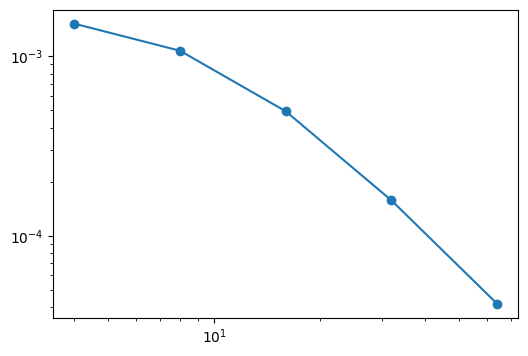

In [20]:
print("  n = %d"%n)
fgp = fastgps.FastGPDigitalNetB2(
    qp.KernelDigShiftInvarCombined(d,torchify=True,device=device),
    qp.DigitalNetB2(d,seed=7),
    )
x_next = fgp.get_x_next(n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_n,pstd_dnb2_n,q,ci_low_dnb2_n,ci_high_dnb2_n = fgp.post_ci(xticks[:,None])
x_dnb2_n,y_dnb2_n = fgp.x.clone(),fgp.y.clone()
print("    posterior cubature var: %-10.2e n=%d: %-10.2e n=%d: %-10.2e"%\
    (fgp.post_cubature_var(),2*n,fgp.post_cubature_var(n=2*n),4*n,fgp.post_cubature_var(n=4*n)))
nprojs = [n,2*n,4*n,8*n,16*n]
vprojs = [fgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(6,4))
ax.set_xscale("log",base=10)
ax.set_yscale("log",base=10)
ax.plot(nprojs,vprojs,'-o');

  n = 8
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.61e+00   | 1.61e+00  
            5.00e+00 | 1.54e+00   | 1.54e+00  
            1.00e+01 | 1.52e+00   | 1.52e+00  
            1.10e+01 | 1.51e+00   | 1.51e+00  
    posterior cubature var: n = 8 8.87e-04  n = 16 4.07e-04  n = 32 1.31e-04  n = 64 3.42e-05  n = 128 8.71e-06  


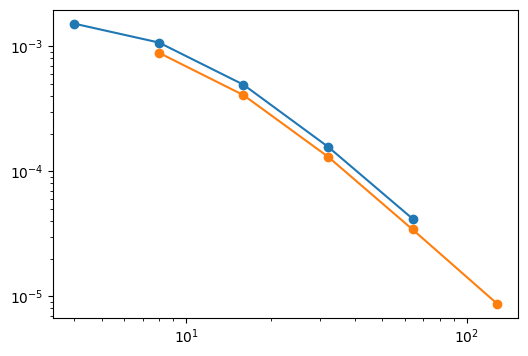

In [21]:
print("  n = %d"%(2*n))
x_next = fgp.get_x_next(2*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_2n,pstd_dnb2_2n,q,ci_low_dnb2_2n,ci_high_dnb2_2n = fgp.post_ci(xticks[:,None])
x_dnb2_2n,y_dnb2_2n = fgp.x.clone(),fgp.y.clone()
nprojs = [2*n,4*n,8*n,16*n,32*n]
vprojs = [fgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
ax.plot(nprojs,vprojs,'-o');
fig

  n = 16
     iter of 5.0e+03 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | -8.58e-01  | -8.58e-01 
            5.00e+00 | -9.31e-01  | -9.27e-01 
            1.00e+01 | -1.10e+00  | -1.10e+00 
            1.50e+01 | -1.28e+00  | -1.16e+00 
            2.00e+01 | -1.28e+00  | -1.28e+00 
            2.30e+01 | -1.28e+00  | -1.28e+00 
    posterior cubature var: n = 16 3.03e-04  n = 32 1.94e-04  n = 64 2.53e-05  n = 128 6.59e-06  n = 256 1.97e-06  


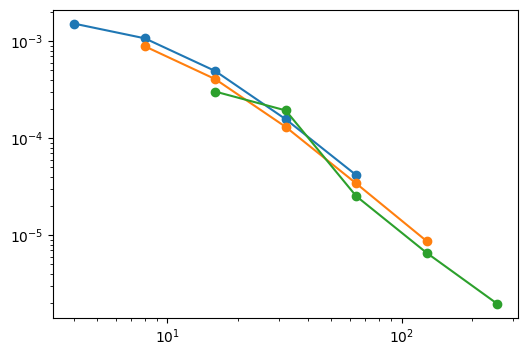

In [22]:
print("  n = %d"%(4*n))
x_next = fgp.get_x_next(4*n)
y_next = f_ackley(x_next)
fgp.add_y_next(y_next)
fgp.fit()
pmean_dnb2_4n,pstd_dnb2_4n,q,ci_low_dnb2_4n,ci_high_dnb2_4n = fgp.post_ci(xticks[:,None])
x_dnb2_4n,y_dnb2_4n = fgp.x.clone(),fgp.y.clone()
nprojs = [4*n,8*n,16*n,32*n,64*n]
vprojs = [fgp.post_cubature_var(n=nproj) for nproj in nprojs]
print("    posterior cubature var: "+(("n = %d %-10.2e")*len(nprojs))%tuple(itertools.chain(*zip(nprojs,vprojs))))
ax.plot(nprojs,vprojs,'-o')
fig

## Collect Data + Plot

In [23]:
data = [
    [
        (x_std_n,y_std_n,pmean_std_n,ci_low_std_n,ci_high_std_n),
        (x_lattice_n,y_lattice_n,pmean_lattice_n,ci_low_lattice_n,ci_high_lattice_n),
        (x_dnb2_n,y_dnb2_n,pmean_dnb2_n,ci_low_dnb2_n,ci_high_dnb2_n)
    ],
    [   
        (x_std_2n,y_std_2n,pmean_std_2n,ci_low_std_2n,ci_high_std_2n),
        (x_lattice_2n,y_lattice_2n,pmean_lattice_2n,ci_low_lattice_2n,ci_high_lattice_2n),
        (x_dnb2_2n,y_dnb2_2n,pmean_dnb2_2n,ci_low_dnb2_2n,ci_high_dnb2_2n)
    ],
    [   
        (x_std_4n,y_std_4n,pmean_std_4n,ci_low_std_4n,ci_high_std_4n),
        (x_lattice_4n,y_lattice_4n,pmean_lattice_4n,ci_low_lattice_4n,ci_high_lattice_4n),
        (x_dnb2_4n,y_dnb2_4n,pmean_dnb2_4n,ci_low_dnb2_4n,ci_high_dnb2_4n)
    ],
]

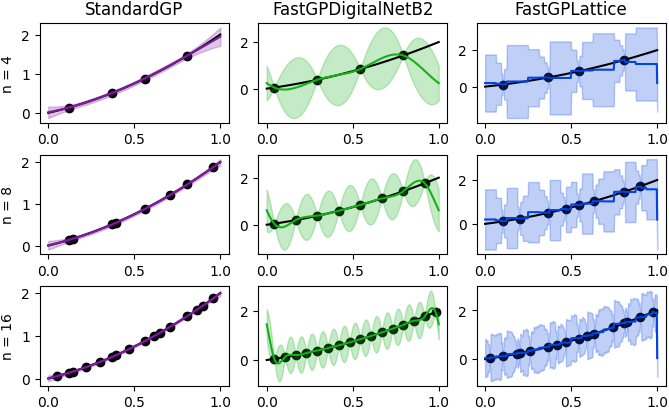

In [24]:
nrows = 3
ncols = len(data[0])
_alpha = 0.25
pyplot.rcParams.update(tueplots.figsizes.icml2024_full(nrows=nrows,ncols=ncols))
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols)
ax = ax.reshape((nrows,ncols))
for i in range(3):
    for j in range(ncols):
        x,y,pmean,ci_low,ci_high = data[i][j]
        ax[i,j].plot(xticks.cpu(),yticks.cpu(),color="k")
        ax[i,j].scatter(x[:,0].cpu(),y.cpu(),color="k")
        ax[i,j].plot(xticks.cpu(),pmean.cpu(),color=colors[j])
        ax[i,j].fill_between(xticks.cpu(),ci_low.cpu(),ci_high.cpu(),color=colors[j],alpha=_alpha)
ax[0,0].set_title("StandardGP")
ax[0,1].set_title("FastGPDigitalNetB2")
ax[0,2].set_title("FastGPLattice")
ax[0,0].set_ylabel(r"n = %d"%n)
ax[1,0].set_ylabel(r"n = %d"%(2*n))
ax[2,0].set_ylabel(r"n = %d"%(4*n))
fig.savefig("./gps.pdf")